In [1]:
from imports import cv2, os, np, tf, ImageDataGenerator, plt, pd, requests
import confidential

firebase_url = confidential.get_url()

response = requests.get(firebase_url)

data = response.json()
data_list = [value for key, value in data.items()]

df = pd.DataFrame(data_list)
df = df[["name", "url"]]

def download_image(url, name):
    response = requests.get(url)
    image_data = response.content
    array = bytearray(image_data)

    image = cv2.imdecode(np.asarray(array, dtype=np.uint8), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (160, 160))
    return image

images = []

for index, row in df.iterrows():
    image = download_image(row["url"], row["name"])
    images.append(image)

images = np.array(images)

2024-04-02 00:07:40.371681: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 00:07:40.371727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 00:07:40.372436: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-02 00:07:40.376802: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-02 00:07:41.025344: W tensorflow/compiler/tf2

In [2]:
print(images.shape)

(4, 160, 160)


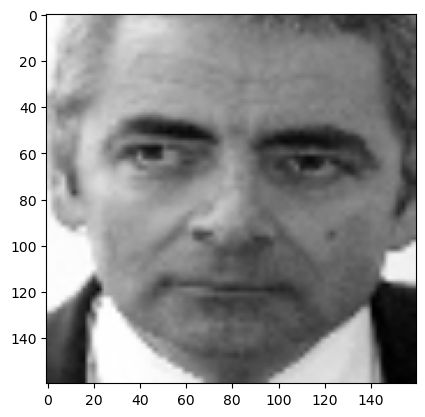

In [3]:
def crop_face(image):
    face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
    faces = face_cascade.detectMultiScale(image, 1.1, 4)
    if len(faces) == 0:
        return None
    for (x, y, w, h) in faces:
        face = cv2.resize(image[y:y+h, x:x+w], (160, 160))
    return face

faces = []

for image in images:
    face = crop_face(image)
    if face is not None:
        faces.append(face)

faces = np.array(faces)

plt.imshow(faces[0], cmap="gray")

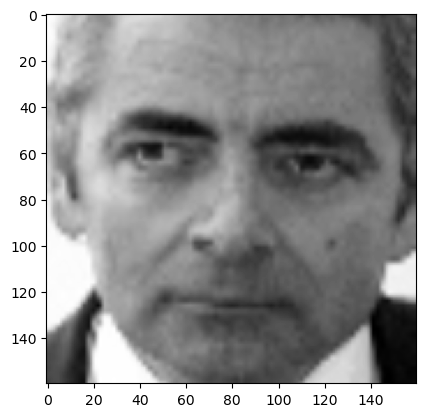

In [4]:
precision = 100

def augment_images(images):
    train_datagen = ImageDataGenerator(rescale=1./255,
                                        rotation_range=40,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        vertical_flip=True,
                                        fill_mode='nearest'
                                        )
    augmented_images = []
    for image in images:
        image = np.expand_dims(image, 0)
        i = 0
        for i in range(precision):
            augmented_images.append(train_datagen.random_transform(image))
            i += 1
            if i >= precision:
                break
    return augmented_images

augmented_images = augment_images(faces)
augmented_images = np.array(augmented_images).reshape(-1, 160, 160)
plt.imshow(augmented_images[50], cmap='gray')

In [5]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=100)
lfw_images = lfw_people.images
lwf_target_names = lfw_people.target_names
lwf_labels = lfw_people.target

In [6]:
lfw_images = [cv2.resize(image, (160, 160)) for image in lfw_images]
lfw_images = np.array(lfw_images)
lwf_labels = np.array(lwf_labels)

In [7]:
names = df["name"].values
labels = np.arange(len(names))
labels += len(lwf_target_names)
labels = np.repeat(labels, precision)
names = np.append(lwf_target_names, names)
labels = np.append(lwf_labels, labels)
images = np.append(lfw_images, augmented_images, axis=0)

In [8]:
classes = len(names)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (2, 2), activation='relu'),
    tf.keras.layers.AveragePooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (2, 2), activation='relu'),
    tf.keras.layers.AveragePooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),
    tf.keras.layers.AveragePooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(classes, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_test, y_test, epochs=150, batch_size=32, validation_data=(X_train, y_train))

Epoch 1/150
10/10 [==============================] - 2s 81ms/step - loss: 6.4555 - accuracy: 0.2922 - val_loss: 5.0463 - val_accuracy: 0.4026
Epoch 2/150
10/10 [==============================] - 0s 40ms/step - loss: 4.8759 - accuracy: 0.4318 - val_loss: 4.4574 - val_accuracy: 0.4651
Epoch 3/150
10/10 [==============================] - 0s 42ms/step - loss: 4.3023 - accuracy: 0.4578 - val_loss: 4.0032 - val_accuracy: 0.4667
Epoch 4/150
10/10 [==============================] - 0s 41ms/step - loss: 3.7972 - accuracy: 0.4481 - val_loss: 3.5384 - val_accuracy: 0.4667
Epoch 5/150
10/10 [==============================] - 0s 41ms/step - loss: 3.4530 - accuracy: 0.4448 - val_loss: 3.2887 - val_accuracy: 0.4375
Epoch 6/150
10/10 [==============================] - 0s 42ms/step - loss: 3.2070 - accuracy: 0.4513 - val_loss: 3.0540 - val_accuracy: 0.4716
Epoch 7/150
10/10 [==============================] - 0s 40ms/step - loss: 2.9968 - accuracy: 0.4838 - val_loss: 2.8657 - val_accuracy: 0.4943
Epoch 

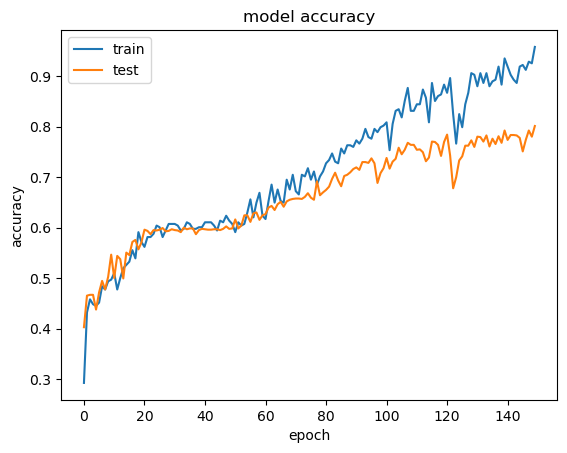

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

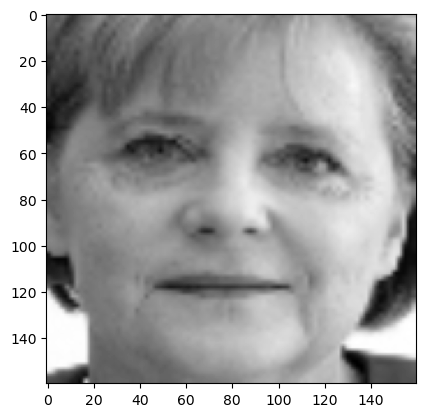

In [37]:
test_image = cv2.imread("test3.jpg")
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
test_image = cv2.resize(test_image, (160, 160))
test_image = crop_face(test_image)
plt.imshow(test_image, cmap='gray')
test_image = np.expand_dims(test_image, 0)

In [38]:
prediction = model.predict(test_image)
print(prediction)

def get_name(prediction):
    if np.max(prediction) < 0.65:
        return "Unknown", 0
    idx = np.argmax(prediction)
    name = names[idx]
    return name, np.max(prediction)

name, p = get_name(prediction)
print(name, p)

1/1 [==============================] - 0s 15ms/step
[[3.0746801e-08 5.0506447e-08 9.2669543e-09 2.4124928e-08 1.7269940e-08
  8.1933825e-07 4.4543913e-04 3.0311366e-08 9.9955350e-01]]
Merkel 0.9995535
